In [ ]:
#!pip3 install prophet

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

Монотонность -  True
RMSE тестовой выборки LinearRegression:  26.675612574152204


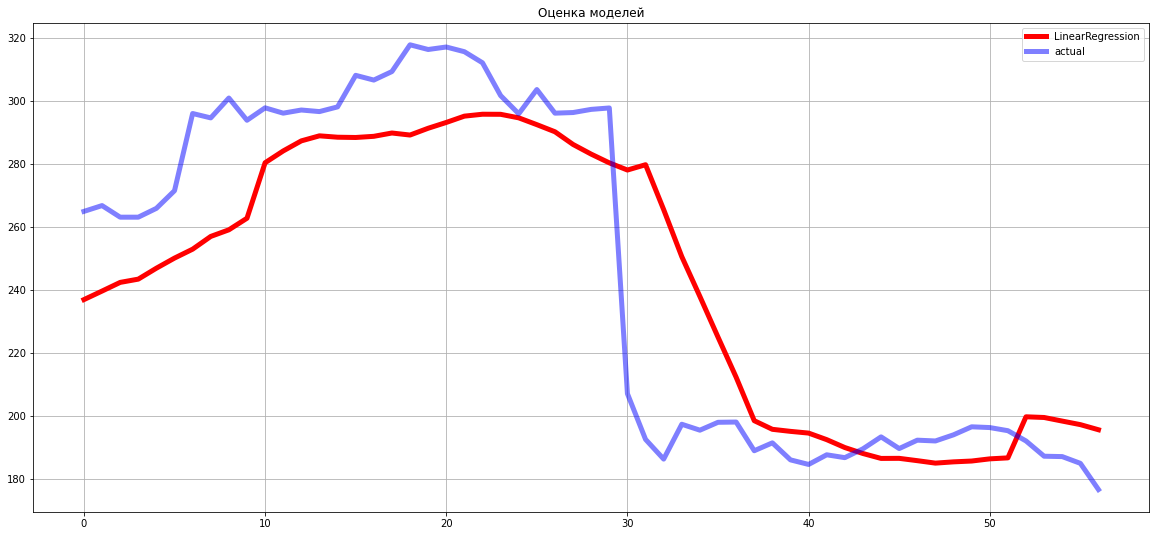

In [12]:
## Линейный прогноз
# Зададим индекс
quotes = pd.read_table('https://raw.githubusercontent.com/RMA1011/da_hw/main/ML/HW2/GAZP_210801_220806.txt', header = 0, sep = ',', parse_dates = ['<DATE>'])
quotes.set_index('<DATE>', inplace = True)
quotes.sort_index(inplace = True)
print('Монотонность - ',quotes.index.is_monotonic)

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['<CLOSE>'].shift(lag)

    data['price_mean'] = data['<CLOSE>'].shift().rolling(rolling_mean_size).mean().copy()

make_features(quotes, 10, 7)

quotes.dropna(inplace = True)

# нужно выбрать отдельные факторы, боимся мультиколлинеарности
features = quotes[['year','month','day','price_mean']]
target = quotes['<CLOSE>']
X_train,X_test,y_train, y_test = train_test_split(features,target, shuffle=False, test_size=0.25)
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_predicted_lr = model_lr.predict(X_test)
print("RMSE тестовой выборки LinearRegression: ",np.sqrt(mean_squared_error(y_test, y_predicted_lr)))
plt.figure(figsize=(20, 9))
plt.plot(y_predicted_lr, "r",linewidth=5, label="LinearRegression")
plt.plot(y_test.values,'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True)



15:49:50 - cmdstanpy - INFO - Chain [1] start processing
15:49:51 - cmdstanpy - INFO - Chain [1] done processing


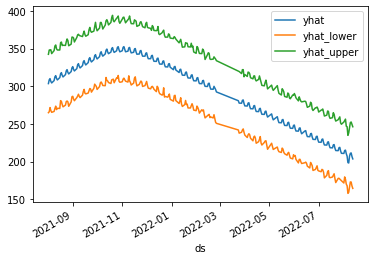

In [14]:
## Пророчим!

m = Prophet()
quotes = pd.read_table('https://raw.githubusercontent.com/RMA1011/da_hw/main/ML/HW2/GAZP_210801_220806.txt', header = 0, sep = ',', parse_dates = ['<DATE>'])
quotes.set_index('<DATE>', inplace = True)
quotes.sort_index(inplace = True)
quotes_prophet = quotes[['<CLOSE>']].reset_index()
quotes_prophet.columns = ['ds','y']
m.fit(quotes_prophet)
future = m.make_future_dataframe(periods=7)
future.tail()
forecast = m.predict(future)
forecast.set_index('ds',inplace=True)
forecast[[ 'yhat', 'yhat_lower', 'yhat_upper']].plot()
